In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)

In [2]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    """
    A grid implementation for the coin-flip problem
    """
    # define a grid
    grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    #prior = (grid  <= 0.4).astype(int)  # truncated
    #prior = abs(grid - 0.5)  # "M" prior

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(heads, tosses, grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

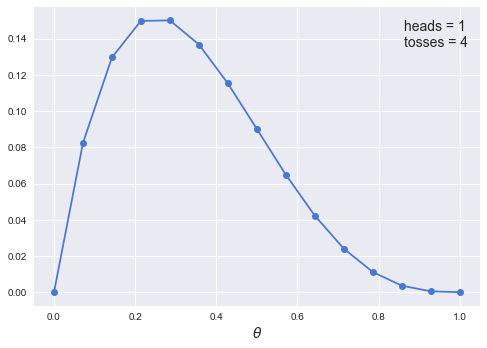

In [3]:
points = 15
h, n = 1, 4
grid, posterior = posterior_grid(points, h, n)
plt.plot(grid, posterior, 'o-')
plt.plot(0, 0, label='heads = {}\ntosses = {}'.format(h, n), alpha=0)
plt.xlabel(r'$\theta$', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.savefig('B04958_02_01.png', dpi=300, figsize=(5.5, 5.5));

## Monte Carlo

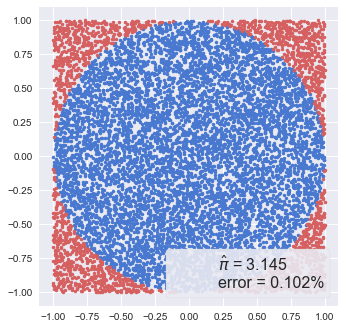

In [4]:
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2)  <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi)/pi)* 100

outside = np.invert(inside)

plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9, fontsize=16);
plt.savefig('B04958_02_02.png', dpi=300, figsize=(5.5, 5.5))

## Metropolis

In [5]:
def metropolis(func, steps=10000):
    """A very simple Metropolis implementation"""
    samples = np.zeros(steps)
    old_x = func.mean()
    old_prob = func.pdf(old_x)

    for i in range(steps):
        new_x = old_x + np.random.normal(0, 1)
        new_prob = func.pdf(new_x)
        acceptance = new_prob/old_prob
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            samples[i] = old_x
    return samples

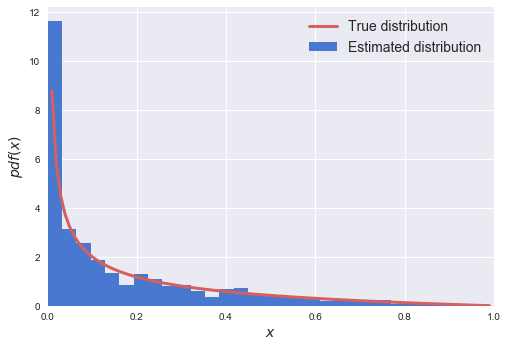

In [6]:
np.random.seed(345)
func = stats.beta(0.4, 2)
samples = metropolis(func=func)
x = np.linspace(0.01, .99, 100)
y = func.pdf(x)
plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='True distribution')
plt.hist(samples, bins=30, normed=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('B04958_02_03.png', dpi=300, figsize=(5.5, 5.5));

## PyMC3 primer

In [7]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([1, 0, 0, 0])

In [8]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=data)
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))
    
    # In the book we use the following lines to run the model, while these are still valid 
    # the recomended way is to let PyMC3 choose the sampler for you
    # Just call pm.sample() or something like pm.sample(1000) to specify the number of productive steps
    #start = pm.find_MAP()
    #step = pm.Metropolis()
    #trace = pm.sample(1000, step=step, start=start)
    trace = pm.sample(1000)  # new recommended way

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 3.1717:   1%|          | 2069/200000 [00:00<00:28, 6888.73it/s]
Convergence archived at 2600
Interrupted at 2,600 [1%]: Average Loss = 3.2221
100%|██████████| 1500/1500 [00:00<00:00, 1594.91it/s]


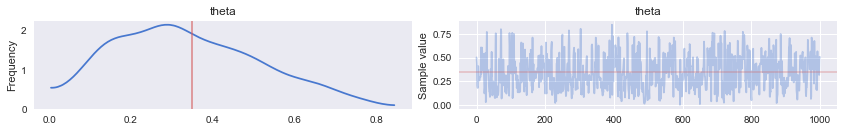

In [9]:
burnin = 0  # no burnin
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});
plt.savefig('B04958_02_04.png', dpi=300, figsize=(5.5, 5.5))

In [10]:
with our_first_model:
    #step = pm.Metropolis()
    #multi_trace = pm.sample(1000, step=step, njobs=4)
    multi_trace = pm.sample(1000, njobs=4)  # new recommended way

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 3.1763:   1%|          | 2008/200000 [00:00<00:29, 6683.76it/s]
Convergence archived at 2600
Interrupted at 2,600 [1%]: Average Loss = 3.2221
100%|██████████| 1500/1500 [00:03<00:00, 486.57it/s]


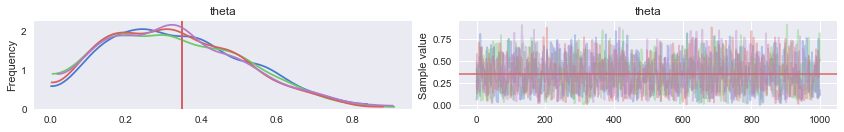

In [11]:
burnin = 0  # no burnin
multi_chain = multi_trace[burnin:]
pm.traceplot(multi_chain, lines={'theta':theta_real});
plt.savefig('B04958_02_06.png', dpi=300, figsize=(5.5, 5.5))

In [12]:
pm.gelman_rubin(multi_chain)

{'theta': 0.9998187518368693, 'theta_logodds__': 0.99993823663008141}

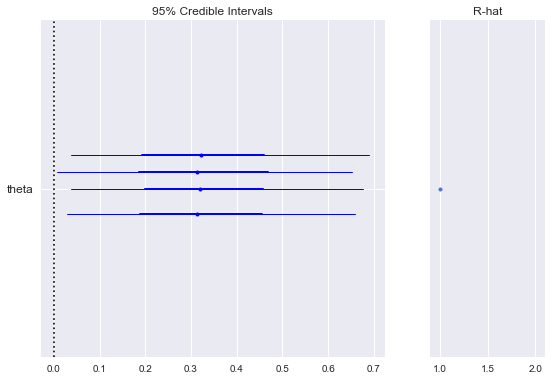

In [13]:
pm.forestplot(multi_chain, varnames=['theta']);
plt.savefig('B04958_02_07.png', dpi=300, figsize=(5.5, 5.5))

In [14]:
pm.summary(multi_chain)


theta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.334            0.178            0.004            [0.028, 0.673]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.053          0.191          0.315          0.459          0.711



In [15]:
pm.df_summary(multi_chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
theta,0.334088,0.178344,0.004153,0.027554,0.673057


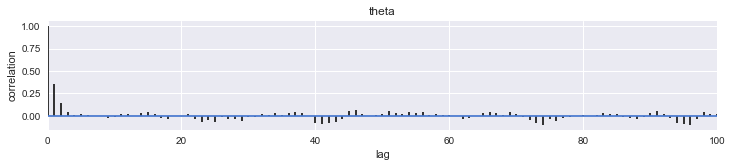

In [16]:
pm.autocorrplot(chain)
plt.savefig('B04958_02_08.png', dpi=300, figsize=(5.5, 5.5))

In [17]:
pm.effective_n(multi_chain)['theta']

1747.0

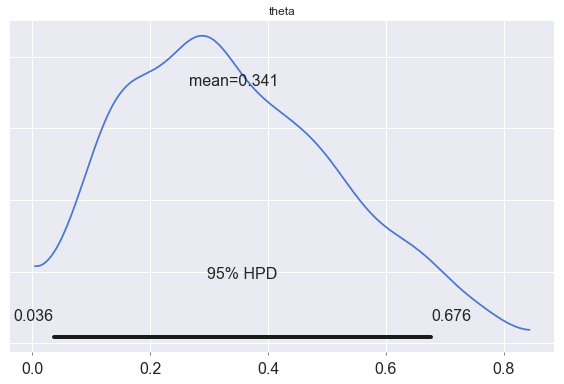

In [18]:
pm.plot_posterior(chain, kde_plot=True)
plt.savefig('B04958_02_09.png', dpi=300, figsize=(5.5, 5.5))

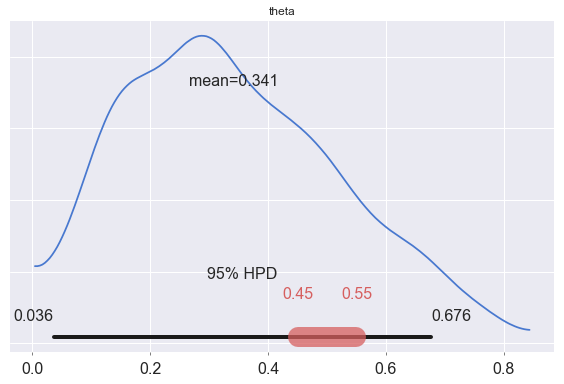

In [19]:
pm.plot_posterior(chain, kde_plot=True, rope=[0.45, .55])
plt.savefig('B04958_02_10.png', dpi=300, figsize=(5.5, 5.5))

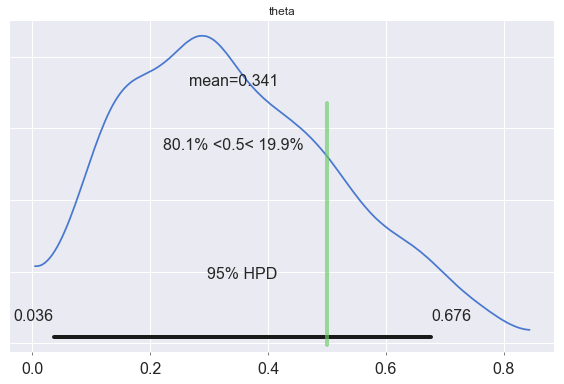

In [20]:
pm.plot_posterior(chain, kde_plot=True, ref_val=0.5)
plt.savefig('B04958_02_11.png', dpi=300, figsize=(5.5, 5.5))

In [21]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a x86_64 computer running debian stretch/sid and using:
Python 3.6.1
IPython 5.3.0
PyMC3 3.1
NumPy 1.12.1
SciPy 0.19.0
Matplotlib 2.0.2
Seaborn 0.7.1
